In [28]:
# %matplotlib widget
# Stdlib packages
import copy
import datetime
import glob
import json
import os
import re
import warnings
from pathlib import Path

# Common Py packages
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from scipy.special import logit as inverse_sigmoid

# HEP packages
import gpustat
import h5py
import hist
import mplhep as hep
import xgboost as xgb
from cycler import cycler

# ML packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from scipy.integrate import trapezoid
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Module packages
from data_processing_BDT import process_data

gpustat.print_gpustat()

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu3.fnal.gov      Fri Dec  6 15:54:46 2024  555.42.06
[0] Tesla P100-PCIE-12GB | 40°C,   0 % |     2 / 12288 MB |


### File Locations and Model Naming

In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

FILEPATHS_DICT = {
    'ggF HH': [
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GluGluToHH/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GluGluToHH/nominal/*"
    ],
    # 'VBF HH': [
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*"
    # ],
    'ttH': [
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/ttHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/ttHToGG/nominal/*"
    ],
    # 'non-res + single-H': [
    #     # non-Resonant #
    #     # GG + 3Jets
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GGJets/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GGJets/nominal/*",
    #     # GJet pT 20-40
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GJetPt20To40/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GJetPt20To40/nominal/*",
    #     # GJet pT 40-inf
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GJetPt40/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GJetPt40/nominal/*",
    #     # single-H #
    #     # ggF H
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GluGluHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GluGluHToGG/nominal/*",
    #     # VBF H
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VBFHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VBFHToGG/nominal/*",
    #     # VH
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VHToGG/nominal/*",
    # ],
    'single-H': [
        # ggF H
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GluGluHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GluGluHToGG/nominal/*",
        # VBF H
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VBFHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VBFHToGG/nominal/*",
        # VH
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VHToGG/nominal/*",
    ],
    'non-res': [
        # GG + 3Jets
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GGJets/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GGJets/nominal/*",
        # GJet pT 20-40
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GJetPt20To40/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GJetPt20To40/nominal/*",
        # GJet pT 40-inf
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GJetPt40/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GJetPt40/nominal/*",
    ],
    # 'VH': [
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v3/VHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v3/VHToGG/nominal/*"
    # ],
}

CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v2'
MOD_VALS = (5, 5)
VARS = 'nonres_and_ttH_and_DNN_vars'
CURRENT_TIME = '2024-11-22_16-40-53'
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}", CURRENT_TIME)
else:
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}")

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

SEED = 21
OPTIMIZE_SPACE = False
NUM_EPOCHS = 150

### Pre-processing Functions

In [3]:
def training_weights(event_weights, labels, order=None, weighttype='rescaled_and_shifted', sig_rescale_factor=None):
    if weighttype == 'abs':
        return np.abs(event_weights)
    
    if order is not None:
        sig_idx = -1
        for i, sample_name in enumerate(order):
            if re.search('ggF HH', sample_name) is not None:
                sig_idx = i
                break
    else:
        sig_idx = 0
    
    if sig_rescale_factor is None:
        sig_sum = np.sum(event_weights[labels[:, sig_idx] == 1])
        bkg_sum = np.sum(event_weights[labels[:, sig_idx] == 0])
        
        sig_rescale_factor = bkg_sum / sig_sum

    scaled_weights = np.where(
        labels[:, sig_idx] == 0, 
        event_weights,  # if bkg, do nothing
        event_weights * sig_rescale_factor  # if sig, rescale to equal sum of all bkgs
    )

    abs_weights = np.abs(scaled_weights)

    if weighttype == 'rescaled':
        return abs_weights
    elif weighttype == 'rescaled_and_shifted':
        mean_weights = np.mean(scaled_weights)
        rescaled_weights = abs_weights / mean_weights
        return rescaled_weights
    else:
        raise ValueError(
            f"The only options for weighttype are 'abs', 'rescaled', and 'rescaled_and_shifted'. You provided {weighttype}"
        )

# def training_weights(event_weights, labels, order=None, sig_rescale_factor=None):
#     if order is None:
#         order = [i for v in range(np.shape(labels)[0])]
#     sum_dict, max_sum, max_i = {}, 0, 0
#     for i, sample_name in enumerate(order):
#         sum_dict[i] = np.sum(event_weights[labels[:, i] == 1])
#         if np.sum(event_weights[labels[:, i] == 1]) > max_sum:
#             max_sum, max_i = np.sum(event_weights[labels[:, i] == 1]), i

#     label_i = np.sum(
#         np.tile([i for i in range(np.shape(labels)[1])], (np.shape(labels)[0], 1)) * labels,
#         axis=1
#     )

#     weight_factors = []
#     for i in range(len(label_i)):
#         weight_factors.append(
#             max_sum / sum_dict[label_i[i]] if label_i[i] != max_i else 1
#         )
#     weights = event_weights * np.array(weight_factors)

#     mean_weight = np.mean(weights)
#     abs_weights = np.abs(weights)
#     scaled_weights = abs_weights / mean_weight

#     return scaled_weights


def xgb_labels(labels):
    label_i = np.sum(
        np.tile([i for i in range(np.shape(labels)[1])], (np.shape(labels)[0], 1)) * labels,
        axis=1
    )

    return label_i

### Data Loading and Input Pre-processing

In [4]:
order = ['ggF HH', 'ttH', 'single-H', 'non-res']

(
    sig_rescale_factor,
    data_df_dict, data_test_df_dict, 
    data_hlf_dict, label_dict,
    data_hlf_test_dict, label_test_dict, 
    hlf_vars_columns_dict,
    data_aux_dict, data_test_aux_dict
) = process_data(
    FILEPATHS_DICT, OUTPUT_DIRPATH, order=order, seed=SEED, mod_vals=MOD_VALS, k_fold_test=True,
    save=False if 'CURRENT_TIME' in globals() else True
)

# Make xgb-like labels (NOT one-hot encoded, but integer encoded for each class)
xgb_label_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}
xgb_label_test_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}

# Make weight dicts:
#   - the top two are with the training rescale (i.e. rescale sig eventWeight to match bkg and then shift for gradients)
#   - the bottom two are the standard eventWeights (i.e. xs * lumi * genWeight) for proper plotting
weight_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}'], order=order, sig_rescale_factor=sig_rescale_factor)) for fold_idx in range(len(data_aux_dict))
}
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(training_weights(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_test_dict[f'fold_{fold_idx}'], order=order, sig_rescale_factor=sig_rescale_factor)) for fold_idx in range(len(data_test_aux_dict))
}
weights_plot_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_aux_dict))
}
weights_plot_test = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}

In [5]:
bdt_train_dict, bdt_val_dict, bdt_test_dict = {}, {}, {}

train_data_dict, val_data_dict = {}, {}
xgb_label_train_dict, xgb_label_val_dict = {}, {}
weights_plot_train, weights_plot_val= {}, {}
train_idxs_dict, val_idxs_dict = {}, {}
for fold_idx in range(len(data_df_dict)):
    if re.search('no_std', VARS) is not None:
        print('no standardization')
        train_val_data_dict = {key: value.to_numpy() for key, value in data_df_dict.items()}
        test_data_dict = {key: value.to_numpy() for key, value in data_test_df_dict.items()}
    else:
        train_val_data_dict = data_hlf_dict
        test_data_dict = data_hlf_test_dict
    (
        X_train, X_val, 
        y_train, y_val, 
        weight_train, weight_val, 
        weight_plot_train, weight_plot_val,
        train_idxs, val_idxs
    ) = train_test_split(
        train_val_data_dict[f"fold_{fold_idx}"], xgb_label_dict[f"fold_{fold_idx}"], 
        weight_train_dict[f"fold_{fold_idx}"], weights_plot_train_dict[f"fold_{fold_idx}"],
        range(len(train_val_data_dict[f"fold_{fold_idx}"])),
        test_size=0.2, random_state=21
    )

    train_data_dict[f"fold_{fold_idx}"] = copy.deepcopy(X_train)
    val_data_dict[f"fold_{fold_idx}"] = copy.deepcopy(X_val)

    xgb_label_train_dict[f"fold_{fold_idx}"] = copy.deepcopy(y_train)
    xgb_label_val_dict[f"fold_{fold_idx}"] = copy.deepcopy(y_val)

    weights_plot_train[f"fold_{fold_idx}"] = copy.deepcopy(weight_plot_train)
    weights_plot_val[f"fold_{fold_idx}"] = copy.deepcopy(weight_plot_val)

    train_idxs_dict[f"fold_{fold_idx}"] = copy.deepcopy(train_idxs)
    val_idxs_dict[f"fold_{fold_idx}"] = copy.deepcopy(val_idxs)

    bdt_train_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_train, label=y_train, 
        weight=weight_train,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    bdt_val_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_val, label=y_val, 
        weight=weight_val,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    
    bdt_test_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=test_data_dict[f"fold_{fold_idx}"], label=xgb_label_test_dict[f"fold_{fold_idx}"], 
        weight=np.abs(weight_test_dict[f"fold_{fold_idx}"]),
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )

    print(f"fold {fold_idx}")
    print(f"Num train: {len(y_train)} -> {sum(y_train == 0)} sig & {sum(y_train == 1)} ttH bkg & {sum(y_train == 2)} single-H bkg & {sum(y_train == 3)} non-res bkg")
    print(f"Num val: {len(y_val)} -> {sum(y_val == 0)} sig & {sum(y_val == 1)} ttH bkg & {sum(y_val == 2)} single-H bkg & {sum(y_val == 3)} non-res bkg")
    print(f"Num test: {len(label_test_dict[f'fold_{fold_idx}'])} -> {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([1, 0, 0, 0]))[0]} sig & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 1, 0, 0]))[1]} ttH bkg & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 0, 1, 0]))[2]} single-H bkg & & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 0, 0, 1]))[3]} non-res bkg")
    print('='*60)

    

fold 0
Num train: 1250553 -> 109209 sig & 221927 ttH bkg & 375391 single-H bkg & 544026 non-res bkg
Num val: 312639 -> 27321 sig & 55278 ttH bkg & 93827 single-H bkg & 136213 non-res bkg
Num test: 391785 -> 34224 sig & 69297 ttH bkg & 118173 single-H bkg & & 170091 non-res bkg
fold 1
Num train: 1251336 -> 109163 sig & 221954 ttH bkg & 375690 single-H bkg & 544529 non-res bkg
Num val: 312835 -> 27303 sig & 55498 ttH bkg & 93803 single-H bkg & 136231 non-res bkg
Num test: 390806 -> 34288 sig & 69050 ttH bkg & 117898 single-H bkg & & 169570 non-res bkg
fold 2
Num train: 1250948 -> 109179 sig & 221279 ttH bkg & 376271 single-H bkg & 544219 non-res bkg
Num val: 312737 -> 27459 sig & 55348 ttH bkg & 93951 single-H bkg & 135979 non-res bkg
Num test: 391292 -> 34116 sig & 69875 ttH bkg & 117169 single-H bkg & & 170132 non-res bkg
fold 3
Num train: 1251535 -> 109262 sig & 221529 ttH bkg & 376945 single-H bkg & 543799 non-res bkg
Num val: 312884 -> 27409 sig & 55525 ttH bkg & 93987 single-H bkg 

### Model Parameterization

In [6]:
# https://stackoverflow.com/questions/57986259/multiclass-classification-with-xgboost-classifier
# https://forecastegy.com/posts/xgboost-multiclass-classification-python/
# https://indico.cern.ch/event/915265/contributions/3848138/attachments/2048174/3432202/kunlinRan_bbyy_20200531.pdf

# https://xgboost.readthedocs.io/en/stable/tutorials/intercept.html - for looking at logits level BDT output
# https://indico.cern.ch/event/915265/contributions/3848138/attachments/2048174/3432202/kunlinRan_bbyy_20200531.pdf - ATLAS HHbbgg BDT


param = {}

# Booster parameters
param['eta']              = 0.05 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.5 # fraction of events to train tree on
param['colsample_bytree'] = 0.5 # fraction of features to train tree on
param['num_class']        = np.shape(label_dict['fold_0'])[1] # num classes for multi-class training

# Learning task parameters
param['objective']   = 'multi:softprob'   # objective function
param['eval_metric'] = 'merror'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'mlogloss')]
# param["disable_default_eval_metric"] = True
# param = list(param.items())

num_trees = 1500  # number of trees to make

def thresholded_weighted_merror(predt: np.ndarray, dtrain: xgb.DMatrix, threshold=0.9):
    """Used when there's no custom objective."""
    # No need to do transform, XGBoost handles it internally.
    weights = dtrain.get_weight()
    thresh_weight_merror = np.where(
        np.logical_and(
            np.max(predt, axis=1) >= threshold,
            np.argmax(predt, axis=1) == dtrain.get_label()
        ),
        0,
        weights
    )
    return f'WeightedMError@{threshold:.2f}', np.sum(thresh_weight_merror)

### Model Training

In [ ]:
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH, OLD_TIME = os.path.split(OUTPUT_DIRPATH)
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
OUTPUT_DIRPATH = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME)
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

evals_result_dict = {f"fold_{fold_idx}": dict() for fold_idx in range(len(bdt_train_dict))}
for fold_idx in range(len(bdt_train_dict)):
    print(f"fold {fold_idx}")
    # Train bdt
    evallist = [(bdt_train_dict[f"fold_{fold_idx}"], 'train'), (bdt_test_dict[f"fold_{fold_idx}"], 'test'), (bdt_val_dict[f"fold_{fold_idx}"], 'val')]
    booster = xgb.train(
        param, bdt_train_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
        evals=evallist, early_stopping_rounds=10, verbose_eval=25, evals_result=evals_result_dict[f"fold_{fold_idx}"],
        # custom_metric=thresholded_weighted_merror
    )

    booster.save_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
    
    # Print perf on test dataset
    print(booster.eval(bdt_test_dict[f"fold_{fold_idx}"], name='test', iteration=booster.best_iteration))
    print('='*100)

with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_eval_result.json'), 'w') as f:
    json.dump(evals_result_dict, f)

fold 0


[0]	train-merror:0.05497	train-mlogloss:1.30412	test-merror:0.06191	test-mlogloss:1.30522	val-merror:0.06399	val-mlogloss:1.30552
[25]	train-merror:0.03469	train-mlogloss:0.41265	test-merror:0.04353	test-mlogloss:0.42540	val-merror:0.04396	val-mlogloss:0.42644
[50]	train-merror:0.03046	train-mlogloss:0.19135	test-merror:0.03969	test-mlogloss:0.20993	val-merror:0.04043	val-mlogloss:0.21116
[75]	train-merror:0.02672	train-mlogloss:0.11851	test-merror:0.03710	test-mlogloss:0.14194	val-merror:0.03771	val-mlogloss:0.14318
[100]	train-merror:0.02434	train-mlogloss:0.09026	test-merror:0.03627	test-mlogloss:0.11842	val-merror:0.03729	val-mlogloss:0.11968
[125]	train-merror:0.02188	train-mlogloss:0.07609	test-merror:0.03490	test-mlogloss:0.10748	val-merror:0.03593	val-mlogloss:0.10870
[150]	train-merror:0.01944	train-mlogloss:0.06706	test-merror:0.03363	test-mlogloss:0.10119	val-merror:0.03468	val-mlogloss:0.10237
[175]	train-merror:0.01713	train-mlogloss:0.06023	test-merror:0.03284	test-mloglo

### Performance (ROC) Calculations

In [8]:
base_tpr = np.linspace(0, 1, 5000)  # copied from IN evaluate.py file
roc_baseline = np.zeros(
    (len(bdt_train_dict), len(base_tpr), len(order)), 
    dtype=float
)
area_baseline = np.zeros(
    (len(bdt_train_dict), len(order)), 
    dtype=float
)

BDT_perf = {
    sample_name: copy.deepcopy({
        'base_tpr': base_tpr,
        'class_order': copy.deepcopy(order),
        # test data #
        'preds': [],
        'fprs_density': copy.deepcopy(roc_baseline), 'thresholds_density': copy.deepcopy(roc_baseline), 'areas_density': copy.deepcopy(area_baseline),
        'fprs_weighted': copy.deepcopy(roc_baseline), 'thresholds_weighted': copy.deepcopy(roc_baseline), 'areas_weighted': copy.deepcopy(area_baseline),
        'fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # train data #
        'train_preds': [], 
        'train_fprs_density': copy.deepcopy(roc_baseline), 'train_thresholds_density': copy.deepcopy(roc_baseline), 'train_areas_density': copy.deepcopy(area_baseline),
        'train_fprs_weighted': copy.deepcopy(roc_baseline), 'train_thresholds_weighted': copy.deepcopy(roc_baseline), 'train_areas_weighted': copy.deepcopy(area_baseline),
        'train_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'train_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # val data #
        'val_preds': [],
        'val_fprs_density': copy.deepcopy(roc_baseline), 'val_thresholds_density': copy.deepcopy(roc_baseline), 'val_areas_density': copy.deepcopy(area_baseline),
        'val_fprs_weighted': copy.deepcopy(roc_baseline), 'val_thresholds_weighted': copy.deepcopy(roc_baseline), 'val_areas_weighted': copy.deepcopy(area_baseline),
        'val_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'val_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
    }) for sample_name in order
}

for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):
        booster = xgb.Booster(param)
        booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
    
        for pred_type, dataset in [
            ('train_', bdt_train_dict[f"fold_{fold_idx}"]),
            ('val_', bdt_val_dict[f"fold_{fold_idx}"]),
            ('', bdt_test_dict[f"fold_{fold_idx}"])
        ]:
            BDT_perf[sample_name][pred_type + 'preds'].append(
                booster.predict(
                    dataset, 
                    iteration_range=(0, booster.best_iteration+1)
                ).tolist()
            )

            for i, sample_name_ in enumerate(order):
                
                if sample_name_ == sample_name:
                    event_mask = dataset.get_label() > -1
                    pred_rescale = np.ones_like(event_mask)
                else:
                    event_mask = np.logical_or(dataset.get_label() == j, dataset.get_label() == i)
                    pred_rescale = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] + np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, i][event_mask]
                class_preds = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] / pred_rescale
                class_truths = np.where(dataset.get_label() == j, 1, 0)[event_mask]
                
                for roc_type in ['density', 'weighted']:

                    if roc_type == 'weighted':
                        if re.search('train', pred_type) is not None:
                            roc_weights = weights_plot_train[f"fold_{fold_idx}"][event_mask]
                        elif re.search('val', pred_type) is not None:
                            roc_weights = weights_plot_val[f"fold_{fold_idx}"][event_mask]
                        else:
                            roc_weights = weights_plot_test[f"fold_{fold_idx}"][event_mask]
                    else:
                        roc_weights = None

                    fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                    fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                    threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                    BDT_perf[sample_name][pred_type + 'fprs_' + roc_type][fold_idx][:, i] = fpr_bdt
                    BDT_perf[sample_name][pred_type + 'thresholds_' + roc_type][fold_idx][:, i] = threshold_bdt
                    BDT_perf[sample_name][pred_type + 'areas_' + roc_type][fold_idx][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for pred_type, dataset_dict in [
        ('train_', bdt_train_dict),
        ('val_', bdt_val_dict),
        ('', bdt_test_dict)
    ]:

        flat_preds = np.concatenate(BDT_perf[sample_name][f'{pred_type}preds'], axis=0)
        flat_truths = np.concatenate([dataset_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(dataset_dict))], axis=0)

        for i, sample_name_ in enumerate(order):
            
            if sample_name_ == sample_name:
                event_mask = flat_truths > -1
                pred_rescale = np.ones_like(event_mask)
            else:
                event_mask = np.logical_or(flat_truths == j, flat_truths == i)
                pred_rescale = flat_preds[:, j][event_mask] + flat_preds[:, i][event_mask]
            class_preds = flat_preds[:, j][event_mask] / pred_rescale
            class_truths = np.where(flat_truths == j, 1, 0)[event_mask]
            
            for roc_type in ['density', 'weighted']:

                if roc_type == 'weighted':
                    if re.search('train', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_train[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_train))], axis=0)[event_mask]
                    elif re.search('val', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_val[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_val))], axis=0)[event_mask]
                    else:
                        roc_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_test))], axis=0)[event_mask]
                else:
                    roc_weights = None

                fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                BDT_perf[sample_name][pred_type + 'fprs_sum_' + roc_type][:, i] = fpr_bdt
                BDT_perf[sample_name][pred_type + 'thresholds_sum_' + roc_type][:, i] = threshold_bdt
                BDT_perf[sample_name][pred_type + 'areas_sum_' + roc_type][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for key in BDT_perf[sample_name].keys():
        if type(BDT_perf[sample_name][key]) is list:
            continue
        BDT_perf[sample_name][key] = BDT_perf[sample_name][key].tolist()

    # with h5py.File(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+f"_BDT_ROC_fold{fold_idx}.h5"), "w") as out:
    #     out['FPR'] = fpr_bdt
    #     out['TPR'] = tpr_bdt
    #     out['Thresholds'] = threshold_bdt

with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'w') as f:
    json.dump(BDT_perf, f)

### Plotting Functions

In [26]:
def pad_list(list_of_lists):
    max_length = np.max([len(list_i) for list_i in list_of_lists])
    for list_i in list_of_lists:
        while len(list_i) < max_length:
            list_i.append(list_i[-1])

    return list_of_lists

def plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='png'):
    plot_prefix = plot_prefix + ('_' if plot_prefix != '' else '')
    plot_postfix = plot_postfix + ('_' if plot_postfix != '' else '')
    plot_name = plot_prefix + plot_name + plot_postfix + f'.{format}'

    plot_filepath = os.path.join(plot_dirpath, plot_name)
    return plot_filepath

def plot_train_val_losses(
    losses_arrs, labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix='', linestyles=None,
    losses_std_arrs=None
):
    plt.figure(figsize=(9,7))
    
    if type(losses_arrs[0]) is float:
        losses_arrs = [losses_arrs]
    if linestyles is None:
        linestyles = ['solid'] * len(losses_arrs)
    if labels is None:
        labels = [i for i in range(len(losses_arrs))]

    if losses_std_arrs is not None:
        for i in range(len(losses_std_arrs)):
            plt.fill_between(
                range(len(losses_std_arrs[i])), 
                losses_arrs[i]+losses_std_arrs[i], losses_arrs[i]-losses_std_arrs[i],
                alpha=0.7
            )

    for i in range(len(losses_arrs)):
        plt.plot(
            range(len(losses_arrs[i])), 
            losses_arrs[i], 
            label=f"{labels[i]} losses", linestyle=linestyles[i],
            alpha=0.7
        )
        
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_rocs(
    fprs, tprs, labels, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', close=True, log=None
):
    plt.figure(figsize=(9,7))
    
    for fpr, tpr, label in zip(fprs, tprs, labels):
        linestyle = 'solid' if re.search('IN', label) is not None else ('dashed' if re.search('BDT', label) is not None else 'dotted')
        plt.plot(fpr, tpr, label=label, linestyle=linestyle)

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    if log is not None and re.search('x', log) is not None:
        plt.xscale('log')
    elif log is not None and re.search('y', log) is not None:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    if close:
        plt.close()

def plot_output_scores(
    sigs_and_bkgs, order, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=600, weights=None, log=False, arctanh=False
):
    plt.figure(figsize=(9,7))

    if arctanh:
        end_point = 6.
    else:
        end_point = 1.
    hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    hists, labels = [], []
    for sample_name in order:
        if sample_name not in sigs_and_bkgs:
            continue
        hists.append(
            hist.Hist(hist_axis, storage='weight').fill(
                var=sigs_and_bkgs[sample_name], 
                weight=weights[sample_name] if weights is not None else np.ones_like(sigs_and_bkgs[sample_name])
            )
        )
        labels.append(sample_name)
    hep.histplot(
        hists,
        yerr=(True if weights is not None else False),
        alpha=0.2, density=(False if weights is not None else True), histtype='step',
        label=labels
    )

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    if log:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_s_over_root_b(
    sig, bkg, label, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=10000, weights={'sig': None, 'bkg': None},
    lines=None, lines_labels=None, line_colors=None, arctanh=False
):
    plt.figure(figsize=(9,7))

    if arctanh:
        end_point = 6.
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    else:
        end_point = 1.
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig))
    bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg))
    s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
    plt.plot(
        np.arange(0., end_point, end_point*(1/bins)), s_over_root_b_points, 
        label=f'{label} - s/√b', alpha=0.8
    )

    if lines is not None:
        for i in range(len(lines)):
            plt.vlines(
                lines[i], 0, np.max(s_over_root_b_points), 
                label='s/√b'+(' - '+lines_labels[i] if lines_labels is not None else ''), 
                alpha=0.5, colors=line_colors[i]
            )
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    plt.ylabel('s/√b')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_confusion_matrix(
    conf_matrix, class_labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix=''
):
    plt.figure(figsize=(9,7))

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
    disp.plot(im_kw={'norm': 'log'})
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_feature_importance(
    feature_scores, feature_labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix='', fscore_method='total_gain', log=True
):
    plt.figure(figsize=(18,14))

    plt.barh(
        np.arange(len(feature_scores)), feature_scores, align='center'
    )
    plt.yticks(np.arange(len(feature_scores)), feature_labels, fontsize=8)
    plt.ylabel('Features')
    plt.xlabel(f'F score ({fscore_method})')
    if log:
        plt.xscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

In [8]:
def optimize_cut_boundaries(sigs, bkgs, weights, bins=10000, arctanh=False):
    hist_list_fold = []
    cut_boundaries_fold = []
    cut_s_over_root_bs_fold = []
    sig_weights_fold = []
    bkg_weights_fold = []
    if len(np.shape(sigs)) == 1:
        sigs, bkgs = [sigs], [bkgs] 
    if arctanh:
        end_point = 6.
    else:
        end_point = 1.
    for sig, bkg in zip(sigs, bkgs):
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'])
        hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

        fold_idx_cuts_bins_inclusive = []
        fold_idx_sig_weights = []
        fold_idx_bkg_weights = []
        fold_idx_prev_s_over_root_b = []
        prev_s_over_root_b = 0
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b) or s < 0.25:
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                fold_idx_sig_weights.append(
                    {
                        'value': np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_bkg_weights.append(
                    {
                        'value': np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_cuts_bins_inclusive.append(bins - i)
                fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        fold_idx_sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_cuts_bins_inclusive.append(0)
        fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
        fold_idx_score_cuts = [end_point * (bin_i / bins) for bin_i in fold_idx_cuts_bins_inclusive]
        cut_boundaries_fold.append(fold_idx_score_cuts)
        cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
        sig_weights_fold.append(fold_idx_sig_weights)
        bkg_weights_fold.append(fold_idx_bkg_weights)
    return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold

In [9]:
def optimize_cuts(
    preds: np.ndarray, binary_labels: np.ndarray, weights: np.ndarray,
    init_guess=[0.99, np.pi/2, 0.], param_range=[(0., 1.), (0., np.pi), (0., 2*np.pi)], n_steps=int(1e3), verbose: bool=False
):
    space  = [Real(float(param_range[i][0]), float(param_range[i][1]), "uniform", name=param_name) for i, param_name in enumerate(['radius', 'theta', 'phi'])]

    space_transform = {
        order[0]: lambda radius, theta, phi: radius * np.sin(theta) * np.cos(phi),
        order[1]: lambda radius, theta, phi: radius * np.sin(theta) * np.sin(phi),
        order[2]: lambda radius, theta, phi: radius * np.cos(theta),
        order[3]: lambda radius, theta, phi: 1. - radius
    }

    @use_named_args(space)
    def objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        sample_mask = np.ones_like(binary_labels, dtype=bool)
        for i, sample_name in enumerate(order):

            threshold = space_transform[sample_name](X['radius'], X['theta'], X['phi'])
            sample_mask = np.logical_and(
                sample_mask,
                preds[:, i] > threshold
            )

        num_sig = np.abs(
            np.sum(
                weights[
                    np.logical_and(
                        binary_labels == 1,
                        sample_mask
                    )
                ]
            )
        )

        num_bkg = np.abs(
            np.sum(
                weights[
                    np.logical_and(
                        binary_labels == 0,
                        sample_mask
                    )
                ]
            )
        )

        s_over_root_b = num_sig / np.sqrt(num_bkg)

        if num_sig == 0 and num_bkg == 0:
            both_0 = 1e4
            if verbose:
                print(f"both sig and bkg 0 at this hyperplane => {both_0}")
            return both_0

        if verbose:
            print(f"s/√b = {s_over_root_b}, s = {num_sig}, b = {num_bkg}")

        return -np.exp(s_over_root_b)
    
    res_gp = gp_minimize(objective, space, random_state=21, n_calls=n_steps, n_initial_points=n_steps)
    print("Best parameters: {}".format(res_gp.x))
    print(f"Best s/√b = {np.log(-res_gp.fun)}")

    opt_cuts = [float(res_gp.x[i]) for i in range(len(space))]
    return opt_cuts


def multi_optimize_cut_boundaries(preds: list, binary_labels: np.ndarray, weights: np.ndarray, num_categories: int=3):
    clf_dict = {}
    for cat in range(num_categories):
        clf_dict[cat] = []
        if cat == 0:
            clf_dict[cat].append([1., 1., 1., 1.])
            sliced_preds = np.array(preds)
            sliced_labels = binary_labels
            sliced_weights = weights

            guess = [0.99, 0., 0., 0.]
        else:
            clf_dict[cat].append(copy.deepcopy(clf_dict[cat-1][-1]))
            slice_array = np.ones_like(binary_labels, dtype=bool)
            for prev_cat in range(cat):
                slice_array = np.logical_and(
                    slice_array,
                    np.logical_not(clf_dict[prev_cat].predict(preds))
                )
            sliced_preds = np.array(preds)[slice_array]
            sliced_labels = binary_labels[slice_array]
            sliced_weights = weights[slice_array]

            guess = [(guess_i - 0.05) if (guess_i - 0.05) > 0. else 0. for guess_i in clf_dict[cat-1][-1]]
        opt_cuts = optimize_cuts(sliced_preds, sliced_labels, sliced_weights)

        clf_dict[cat].append(opt_cuts)

    return clf_dict


### Loss per Epoch Plots

In [11]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "losses")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

if 'evals_result_dict' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_eval_result.json"), 'r') as f:
        evals_result_dict = json.load(f)

# plot train/val/test losses
all_train, all_val, all_test = [], [], []
for fold_idx in range(len(evals_result_dict)):
    all_train.append(evals_result_dict[f"fold_{fold_idx}"]['train']['mlogloss'])
    all_val.append(evals_result_dict[f"fold_{fold_idx}"]['val']['mlogloss'])
    all_test.append(evals_result_dict[f"fold_{fold_idx}"]['test']['mlogloss'])

plot_train_val_losses(
    all_train + all_val, [f'train fold {i}' for i in range(len(all_train))]+[f'val fold {i}' for i in range(len(all_val))],
    'train_val_losses_vs_epoch', plot_dirpath, 
    linestyles=['solid']*len(all_train) + ['dashed']*len(all_val),
)
plot_train_val_losses(
    all_train + all_test, [f'train fold {i}' for i in range(len(all_train))]+[f'test fold {i}' for i in range(len(all_test))],
    'train_test_losses_vs_epoch', plot_dirpath,
    linestyles=['solid']*len(all_train) + ['dotted']*len(all_test),
)
avg_train, avg_val, avg_test = np.mean(pad_list(all_train), axis=0), np.mean(pad_list(all_val), axis=0), np.mean(pad_list(all_test), axis=0)
std_train, std_val, std_test = np.std(pad_list(all_train), axis=0), np.std(pad_list(all_val), axis=0), np.std(pad_list(all_test), axis=0)
plot_train_val_losses(
    [avg_train, avg_val, avg_test], ['train avg', 'val avg', 'test avg'],
    'train_val_test_avg_vs_epoch', plot_dirpath,
    losses_std_arrs=[std_train, std_val, std_test],
    linestyles=['solid', 'dashed', 'dotted'],
)

### ROC Plots

In [12]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "ROCs")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

base_tpr = np.array(BDT_perf['ggF HH']['base_tpr'])

# plot ROCs
for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):

        for roc_type in ['density', 'weighted']:

            fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'][fold_idx])[:, i] for i in range(len(order))]
            tprs = [base_tpr for _ in range(len(order))]
            labels = [
                f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][fold_idx][i]:.4f}" 
                for i, sample_name_ in enumerate(order)
            ]

            plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_fold{fold_idx}", plot_dirpath)

    for roc_type in ['sum_density', 'sum_weighted']:

        fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'])[:, i] for i in range(len(order))]
        tprs = [base_tpr for _ in range(len(order))]
        labels = [
            f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][i]:.4f}" 
            for i, sample_name_ in enumerate(order)
        ]

        plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_sum", plot_dirpath)

### Output Score Dist Plots

In [29]:
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores")
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores_arctanh")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot Output scores
for j, sample_name in enumerate(order):

    for i, sample_name_ in enumerate(order):

        for fold_idx in range(len(bdt_train_dict)):
            
            sigs_and_bkgs = {
                sample_name__: np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }
            score_weights = {
                sample_name__: weights_plot_test[f"fold_{fold_idx}"][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }

            if sample_name_ != sample_name:
                event_j_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                pred_j_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_j_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_j_mask]
                event_i_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == i
                pred_i_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_i_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_i_mask]

                for sample_name__ in order:
                    if sample_name__ == sample_name:
                        sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_j_rescale
                    elif sample_name__ == sample_name_:
                        sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_i_rescale
                    else:
                        del sigs_and_bkgs[sample_name__]
                        del score_weights[sample_name__]

            if re.search('arctanh', plot_dirpath) is not None:
                for key, value in sigs_and_bkgs.items():
                    sigs_and_bkgs[key] = np.arctanh(value)

            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreWeighted_testData_fold{fold_idx}", 
                plot_dirpath, weights=score_weights, log=True,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )
            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreDensity_testData_fold{fold_idx}", 
                plot_dirpath,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

        flat_preds = np.concatenate([BDT_perf[sample_name]['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0)
        if re.search('arctanh', plot_dirpath) is not None:
            flat_preds = np.arctanh(flat_preds)
        flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
        flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)

        sigs_and_bkgs = {
            sample_name__: flat_preds[:, j][flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        score_weights = {
            sample_name__: flat_weights[flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        
        if sample_name_ != sample_name:
            event_j_mask = flat_truths == j
            pred_j_rescale = (flat_preds[:, j] + flat_preds[:, i])[event_j_mask]
            event_i_mask = flat_truths == i
            pred_i_rescale = (flat_preds[:, j] + flat_preds[:, i])[event_i_mask]

            for sample_name__ in order:
                if sample_name__ == sample_name:
                    sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_j_rescale
                elif sample_name__ == sample_name_:
                    sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_i_rescale
                else:
                    del sigs_and_bkgs[sample_name__]
                    del score_weights[sample_name__]
        
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreWeighted_testData_sum", 
            plot_dirpath, weights=score_weights, log=True,
            arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
        )
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreDensity_testData_sum", 
            plot_dirpath,
            arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
        )



### s/√b Plots

In [17]:
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb")
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb_arctanh")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot s/√b curves
for j, sample_name in enumerate(order):

    for i, sample_name_ in enumerate(order):

        for fold_idx in range(len(bdt_train_dict)):

            if sample_name_ == sample_name:
                sig_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                bkg_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() != j

                sig_rescale = np.ones_like(sig_mask)
                bkg_rescale = np.ones_like(bkg_mask)
            else:
                sig_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                bkg_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == i

                sig_rescale = (
                    np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] 
                    + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i]
                )
                bkg_rescale = (
                    np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] 
                    + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i]
                )

            sigs_and_bkgs = {
                'sig': (np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] / sig_rescale)[sig_mask],
                'bkg': (np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] / bkg_rescale)[bkg_mask]
            }
            if re.search('arctanh', plot_dirpath) is not None:
                sigs_and_bkgs['sig'] = np.arctanh(sigs_and_bkgs['sig'])
                sigs_and_bkgs['bkg'] = np.arctanh(sigs_and_bkgs['bkg'])
            score_weights = {
                'sig': weights_plot_test[f"fold_{fold_idx}"][sig_mask],
                'bkg': weights_plot_test[f"fold_{fold_idx}"][bkg_mask]
            }


            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                plot_s_over_root_b(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                    f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_testData_fold{fold_idx}", 
                    plot_dirpath, weights=score_weights,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False  
                )

                (
                    cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
                ) = optimize_cut_boundaries(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], score_weights,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
                )

                BDT_cut_labels = [
                    f"cut={cut_boundaries_fold[0][cut_idx]:.4f}: s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.5f}, s={sig_weights_fold[0][cut_idx]['value']:.5f}±{sig_weights_fold[0][cut_idx]['w2']:.5f}, b={bkg_weights_fold[0][cut_idx]['value']:.5f}±{bkg_weights_fold[0][cut_idx]['w2']:.5f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
                ]
                line_labels = BDT_cut_labels[:10]
                lines = cut_boundaries_fold[0][:10]
                line_colors = cmap_petroff10

                plot_s_over_root_b(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                    f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_fold{fold_idx}_{sample_name}", plot_dirpath, 
                    weights=score_weights,
                    lines=lines, lines_labels=line_labels, line_colors=line_colors,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
                )
            
        flat_preds = np.concatenate([BDT_perf[sample_name]['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0)
        if re.search('arctanh', plot_dirpath) is not None:
            flat_preds = np.arctanh(flat_preds)
        flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
        flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)

        if sample_name_ == sample_name:
            sig_mask = flat_truths == j
            bkg_mask = flat_truths != j

            sig_rescale = np.ones_like(sig_mask)
            bkg_rescale = np.ones_like(bkg_mask)
        else:
            sig_mask = flat_truths == j
            bkg_mask = flat_truths == i

            sig_rescale = flat_preds[:, j] + flat_preds[:, i]
            bkg_rescale = flat_preds[:, j] + flat_preds[:, i]

        sigs_and_bkgs = {
            'sig': (flat_preds[:, j] / sig_rescale)[sig_mask],
            'bkg': (flat_preds[:, j] / bkg_rescale)[bkg_mask]
        }
        score_weights = {
            'sig': flat_weights[sig_mask],
            'bkg': flat_weights[bkg_mask]
        }

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plot_s_over_root_b(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_testData_sum", 
                plot_dirpath, weights=score_weights,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

            (
                cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
            ) = optimize_cut_boundaries(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], score_weights,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

            BDT_cut_labels = [
                f"cut={cut_boundaries_fold[0][cut_idx]:.4f}: s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.5f}, s={sig_weights_fold[0][cut_idx]['value']:.5f}±{sig_weights_fold[0][cut_idx]['w2']:.5f}, b={bkg_weights_fold[0][cut_idx]['value']:.5f}±{bkg_weights_fold[0][cut_idx]['w2']:.5f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
            ]
            line_labels = BDT_cut_labels[:10]
            lines = cut_boundaries_fold[0][:10]
            line_colors = cmap_petroff10

            plot_s_over_root_b(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_sum", plot_dirpath, 
                weights=score_weights,
                lines=lines, lines_labels=line_labels, line_colors=line_colors,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

        if j == 0 and i == 0:
            flat_mass = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['mass'] for fold_idx in range(len(data_test_aux_dict))], axis=0)
            if re.search('arctanh', plot_dirpath) is not None:
                cat_lines = [6.0] + lines[:3]
            else:
                cat_lines = [1.0] + lines[:3]
            cat_num_samples = {}
            for k, cat in enumerate(['Cat1', 'Cat2', 'Cat3']):
                cat_num_samples[cat] = {}
                print('='*60)
                print('='*60)
                print(f"{cat}: {cat_lines[k+1]:.4f} < ggF HH score ≤ {cat_lines[k]:.4f} AND 120 GeV < m_HH < 130 GeV")
                print('-'*60)
                for m, sample_name in enumerate(order):
                    cat_num_samples[cat][sample_name] = np.sum(
                        flat_weights[
                            np.logical_and(  # event passes conditions and is the right type (i.e. sample)
                                np.logical_and(  # event passes category and mass conditions
                                    np.logical_and(  # prediction is within category bounds
                                        flat_preds[:, 0] <= cat_lines[k],
                                        flat_preds[:, 0] > cat_lines[k+1]
                                    ),
                                    np.logical_and(  # diphoton mass is within 120-130 window
                                        flat_mass < 130,
                                        flat_mass > 120
                                    ),
                                ),
                                flat_truths == m
                            )
                        ]
                    )
                    print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
                    print('-'*60)

                print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")



Cat1: 4.2906 < ggF HH score ≤ 6.0000 AND 120 GeV < m_HH < 130 GeV
------------------------------------------------------------
Cat1: Num ggF HH = 0.2440
------------------------------------------------------------
Cat1: Num ttH = 0.0739
------------------------------------------------------------
Cat1: Num single-H = 0.1945
------------------------------------------------------------
Cat1: Num non-res = 0.6804
------------------------------------------------------------
Cat1: S = 0.2440, B = 0.9487, S/√B = 0.2505
Cat2: 3.6270 < ggF HH score ≤ 4.2906 AND 120 GeV < m_HH < 130 GeV
------------------------------------------------------------
Cat2: Num ggF HH = 0.2435
------------------------------------------------------------
Cat2: Num ttH = 0.5134
------------------------------------------------------------
Cat2: Num single-H = 0.4745
------------------------------------------------------------
Cat2: Num non-res = 3.4820
------------------------------------------------------------
Cat2: 

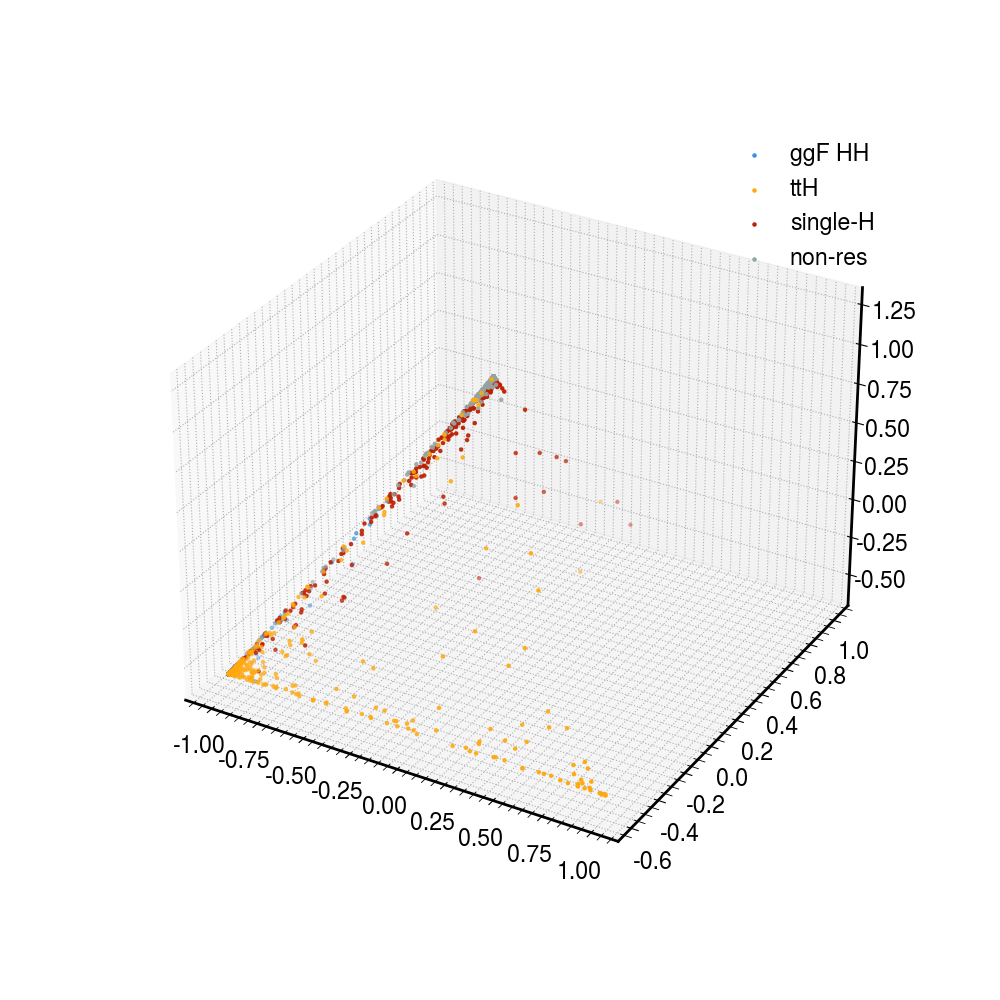

Best parameters: [0.9895606890266092, 2.081052888875674, 5.272950452610993]
Best s/√b = 0.0016649448189253117


AttributeError: 'list' object has no attribute 'predict'

In [17]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb_multiOptim")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# def p_to_xyz(p):
#     x = p[:, 0] + p[:, 1] - p[:, 2] - p[:, 3]
#     y = p[:, 0] - p[:, 1] + p[:, 2] - p[:, 3]
#     z = p[:, 0] - p[:, 1] - p[:, 2] + p[:, 3]

#     return x, y, z
def p_to_xyz(p):
    s3 = 1/np.sqrt(3.0)
    s6 = 1/np.sqrt(6.0)
    x =  -1*p[:, 0] +  1*p[:, 1] +    0*p[:, 2] +    0*p[:, 3]
    y = -s3*p[:, 0] - s3*p[:, 1] + 2*s3*p[:, 2] +    0*p[:, 3]
    z = -s3*p[:, 0] - s3*p[:, 1] -   s3*p[:, 2] + 3*s6*p[:, 3]
    return x, y, z

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# x_preds, y_preds, z_preds = p_to_xyz(np.concatenate([BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0))
for i, sample_name in enumerate(order):
    if i == 0:
        downsample = 100
    elif i == 1:
        downsample = 200
    elif i == 2:
        downsample = 400
    elif i == 3:
        downsample = 500

    x_preds, y_preds, z_preds = p_to_xyz(np.array(BDT_perf['ggF HH']['preds'][0])[bdt_test_dict[f"fold_{fold_idx}"].get_label() == i][::downsample])
    ax.scatter(x_preds, y_preds, z_preds, marker='.', label=sample_name)
plt.legend()
plt.show()

# plot s/√b curves
for fold_idx in range(len(bdt_train_dict)):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        clf_dict = multi_optimize_cut_boundaries(
            BDT_perf['ggF HH']['preds'][fold_idx], 
            bdt_test_dict[f"fold_{fold_idx}"].get_label() == 0, 
            weights_plot_test[f"fold_{fold_idx}"]
            # weight_test_dict[f"fold_{fold_idx}"]
        )

    cat_dict = {}
    for cat in range(len(clf_dict)):
        prev_cat_slice = np.ones_like(weights_plot_test[f"fold_{fold_idx}"], dtype=bool)
        if cat > 0:
            for prev_cat in range(cat):
                prev_cat_slice = np.logical_and(
                    prev_cat_slice,
                    np.logical_not(clf_dict[prev_cat].predict(BDT_perf['ggF HH']['preds'][fold_idx]))
                )
        cat_dict[cat] = np.logical_and(
            clf_dict[cat].predict(BDT_perf['ggF HH']['preds'][fold_idx]),
            prev_cat_slice
        )

    masses = data_test_aux_dict[f"fold_{fold_idx}"]['mass']
    cat_num_samples = {}
    for cat in range(len(clf_dict)):
        cat_num_samples[cat] = {}
        print('='*60)
        print('='*60)
        print(f"Fold {fold_idx}: Category {cat} (SVM) AND 120 GeV < m_HH < 130 GeV")
        print('-'*60)
        for m, sample_name in enumerate(order):
            cat_num_samples[cat][sample_name] = np.sum(
                weights_plot_test[f"fold_{fold_idx}"][
                    np.logical_and(  # event passes conditions and is the right type (i.e. sample)
                        np.logical_and(  # event passes category and mass conditions
                            cat_dict[cat],  # event passes category selections
                            np.logical_and(  # diphoton mass is within 120-130 window
                                masses < 130,
                                masses > 120
                            ),
                        ),
                        bdt_test_dict[f"fold_{fold_idx}"].get_label() == m
                    )
                ]
            )
            print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
            print('-'*60)
        print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")

print('='*60)
print('='*60)
print('='*60)
print('='*60)

flat_preds = np.concatenate([BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0)
flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)
# flat_weights = np.concatenate([weight_test_dict[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clf_dict = multi_optimize_cut_boundaries(
        flat_preds, flat_truths, flat_weights
    )

    # plot_s_over_root_b(
    #     sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
    #     f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_sum", plot_dirpath, 
    #     weights=score_weights,
    #     lines=lines, lines_labels=line_labels, line_colors=line_colors
    # )

flat_mass = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['mass'] for fold_idx in range(len(data_test_aux_dict))], axis=0)
cat_dict = {}
for cat in range(len(clf_dict)):
    prev_cat_slice = np.ones_like(flat_weights, dtype=bool)
    if cat > 0:
        cat_ = cat - 1
        while cat_ >= 0:
            prev_cat_slice = np.logical_and(
                prev_cat_slice,
                np.logical_not(clf_dict[cat_].predict(flat_preds))
            )
            cat_ -= 1
    cat_dict[cat] = np.logical_and(
        clf_dict[cat].predict(flat_preds),
        prev_cat_slice
    )

masses = data_test_aux_dict[f"fold_{fold_idx}"]['mass']
cat_num_samples = {}
for cat in range(len(clf_dict)):
    cat_num_samples[cat] = {}
    print('='*60)
    print('='*60)
    print(f"Category {cat} (SVM) AND 120 GeV < m_HH < 130 GeV")
    print('-'*60)
    for m, sample_name in enumerate(order):
        cat_num_samples[cat][sample_name] = np.sum(
            flat_weights[
                np.logical_and(  # event passes conditions and is the right type (i.e. sample)
                    np.logical_and(  # event passes category and mass conditions
                        cat_dict[cat],  # event passes category selections
                        np.logical_and(  # diphoton mass is within 120-130 window
                            masses < 130,
                            masses > 120
                        ),
                    ),
                    flat_truths == m
                )
            ]
        )
        print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
        print('-'*60)
    print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")



### Confusion Matrix

In [ ]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "confusion_matrix")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

for fold_idx in range(len(BDT_perf['ggF HH']['preds'])):

    pred_classes = np.argmax(BDT_perf['ggF HH']['preds'][fold_idx], axis=1)

    conf_matrix = confusion_matrix(
        bdt_test_dict[f"fold_{fold_idx}"].get_label(), 
        pred_classes,
        sample_weight=weights_plot_test[f"fold_{fold_idx}"]
    )

    plot_confusion_matrix(
        conf_matrix, order, f"confusion_matrix_fold{fold_idx}", plot_dirpath
    )

    f1_scores = f1_score(
        bdt_test_dict[f"fold_{fold_idx}"].get_label(), 
        pred_classes,
        labels=order,
        sample_weight=weights_plot_test[f"fold_{fold_idx}"], average='weighted'
    )
    print(f"fold {fold_idx}: F1 scores = \n{f1_scores}")

full_pred_classes = np.argmax(
    np.concatenate(
        [
            BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
        ]
    ), axis=1
)
full_labels = np.concatenate(
    [
        bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
    ]
)
full_weights = np.concatenate(
    [
        weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
    ]
)

conf_matrix = confusion_matrix(
    full_labels, 
    full_pred_classes,
    sample_weight=full_weights
)

plot_confusion_matrix(
    conf_matrix, order, f"confusion_matrix_sum", plot_dirpath
)

f1_scores = f1_score(
    full_labels, 
    full_pred_classes,
    labels=order,
    sample_weight=full_weights, average='weighted'
)
print(f"Sum over folds: F1 scores = \n{f1_scores}")


### Variable Importance

In [27]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "variable_importance")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

for fold_idx in range(len(bdt_train_dict)):
    booster = xgb.Booster(param, model_file=os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

    labels = copy.deepcopy([key for key in hlf_vars_columns_dict[f'fold_{fold_idx}'].keys()])
    labels.sort()
    
    booster.feature_names = labels
    score_dict = booster.get_score(importance_type='total_gain')

    sorted_scores, sorted_labels = [], []
    for label, score in score_dict.items():
        sorted_scores.append(score)
        sorted_labels.append(label)

    sorted_labels = np.array(sorted_labels)[np.argsort(sorted_scores)]
    sorted_scores = np.sort(sorted_scores)

    plot_feature_importance(
        sorted_scores, sorted_labels, f'xgb_importance_fold{fold_idx}', plot_dirpath
    )

In [18]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    "signal": r"ggF $HH\rightarrow bb\gamma\gamma$ + VBF $HH\rightarrow bb\gamma\gamma$",
    "single-H": r"ggF $H\rightarrow \gamma\gamma$ + VBF $H\rightarrow \gamma\gamma$ + V$H\rightarrow\gamma\gamma$",
    "non-res": r"$\gamma\gamma+3j$ + $\gamma+j$, 20GeV<$p_T$"
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}
LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 150., 2000, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    # 'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    # 'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'lead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'sublead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'sublead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'sublead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Integer(0, 10, name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False),
    'CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
    # Yibo's BDT variables
    'lead_mvaID': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 
    'sublead_mvaID': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{sublead}$ MVA ID', growth=False, underflow=False, overflow=False),
    'CosThetaStar_gg': hist.axis.Regular(50, -1., 1., name='var', label=r'cos$(\theta_{gg})$', growth=False, underflow=False, overflow=False),
    'lead_pt_over_Mgg': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,\gamma_1} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_pt_over_Mgg': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,\gamma_2} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_sigmaE_over_E': hist.axis.Regular(50, 0., 500., name='var', label=r'$\sigma {E,\gamma_1} / E_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_sigmaE_over_E': hist.axis.Regular(50, 0., 500., name='var', label=r'$\sigma {E,\gamma_2} / E_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt_over_Mjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,j1} / M_{jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt_over_Mjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,j2} / M_{jj}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_btagPNetB': hist.axis.Regular(50, -1., 1., name='var', label=r'$j_{lead}$ PNet btag score', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_btagPNetB': hist.axis.Regular(50, -1., 1., name='var', label=r'$j_{sublead}$ PNet btag score', growth=False, underflow=False, overflow=False),
    'lead_bjet_sigmapT_over_pT': hist.axis.Regular(50, 0., 500., name='var', label=r'$\sigma p_{T,j1} / p_{T,jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_sigmapT_over_pT': hist.axis.Regular(50, 0., 500., name='var', label=r'$\sigma p_{T,j2} / p_{T,jj}$', growth=False, underflow=False, overflow=False),
    'dipho_mass_over_Mggjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$M_{\gamma\gamma} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False), 
    'dijet_mass_over_Mggjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$M_{jj} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False),
    # My variables for non-reso reduction #
    'lead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -50., 50., name='var', label=r'$\gamma_{lead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False), 
    'sublead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -50., 50., name='var', label=r'$\gamma_{sublead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False),
    # Michael's DNN variables #
    'DeltaR_j1g1': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j1g2': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g1': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g2': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_pt': hist.axis.Regular(100, 0., 700., name='var', label=r'HH $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_eta': hist.axis.Regular(50, -5., 5., name='var', label=r'HH $\eta$', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_phi': hist.axis.Regular(50, -3.2, 3.2, name='var', label=r'HH $\phi$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_mass': hist.axis.Regular(50, 0., 700., name='var', label=r'$M_{HH}$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($\Sigma E_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'lead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'lead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t0}^2$)', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t1}^2$)', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma$ ln($p_{T}$) [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_CS': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'ln($M_{jj}$) [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
    # Yibo's BDT variables
    'lead_mvaID': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 
    'sublead_mvaID': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{sublead}$ MVA ID', growth=False, underflow=False, overflow=False),
    'CosThetaStar_gg': hist.axis.Regular(50, -4., 4., name='var', label=r'cos$(\theta_{gg})$', growth=False, underflow=False, overflow=False),
    'lead_pt_over_Mgg': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,\gamma_1} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_pt_over_Mgg': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,\gamma_2} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_sigmaE_over_E': hist.axis.Regular(50, -4., 4., name='var', label=r'exp($\sigma {E,\gamma_1} / E_{\gamma\gamma}$)', growth=False, underflow=False, overflow=False), 
    'sublead_sigmaE_over_E': hist.axis.Regular(50, -4., 4., name='var', label=r'exp($\sigma {E,\gamma_2} / E_{\gamma\gamma}$)', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt_over_Mjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,j1} / M_{jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt_over_Mjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,j2} / M_{jj}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_btagPNetB': hist.axis.Regular(50, -4., 4., name='var', label=r'$j_{lead}$ PNet btag score', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_btagPNetB': hist.axis.Regular(50, -4., 4., name='var', label=r'$j_{sublead}$ PNet btag score', growth=False, underflow=False, overflow=False),
    'lead_bjet_sigmapT_over_pT': hist.axis.Regular(50, -4., 4., name='var', label=r'exp($\sigma p_{T,j1} / p_{T,jj}$)', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_sigmapT_over_pT': hist.axis.Regular(50, -4., 4., name='var', label=r'exp($\sigma p_{T,j2} / p_{T,jj}$)', growth=False, underflow=False, overflow=False),
    'dipho_mass_over_Mggjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$M_{\gamma\gamma} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False), 
    'dijet_mass_over_Mggjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$M_{jj} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False),
    # My variables for non-reso reduction #
    'lead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{lead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False), 
    'sublead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{sublead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False),
    # Michael's DNN variables #
    'DeltaR_j1g1': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j1g2': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g1': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g2': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_pt': hist.axis.Regular(100, -4., 4., name='var', label=r'HH ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_eta': hist.axis.Regular(50, -4., 4., name='var', label=r'HH $\eta$', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_phi': hist.axis.Regular(50, -4., 4., name='var', label=r'HH $\phi$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_mass': hist.axis.Regular(50, -4., 4., name='var', label=r'ln($M_{HH}$) [GeV]', growth=False, underflow=False, overflow=False),
}

def post_std_np_arrays(
    data, data_test, fold, var_name, train_index=None, val_index=None
):
    sig_mask = label_dict[f'fold_{fold}'] == 1
    sig_test_mask = label_test_dict[f'fold_{fold}'] == 1
    bkg_mask = label_dict[f'fold_{fold}'] == 0
    bkg_test_mask = label_test_dict[f'fold_{fold}'] == 0
    
    if train_index is not None and val_index is not None:
        sig_train_mask = sig_mask & train_index 
        sig_val_mask = sig_mask & val_index
        bkg_train_mask = bkg_mask & train_index
        bkg_val_mask = bkg_mask & val_index
        
        index2 = hlf_vars_columns_dict[f'fold_{fold}'][var_name]
        sig_train_np = data[sig_train_mask, index2]
        sig_val_np = data[sig_val_mask, index2]
        sig_test_np = data_test[sig_test_mask, index2]
        bkg_train_np = data[bkg_train_mask, index2]
        bkg_val_np = data[bkg_val_mask, index2]
        bkg_test_np = data_test[bkg_test_mask, index2]

        return (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np
        )
    elif train_index is None and val_index is None:
        index2 = hlf_vars_columns_dict[f'fold_{fold}'][var_name]
        sig_train_np = data[sig_mask, index2]
        sig_test_np = data_test[sig_test_mask, index2]
        bkg_train_np = data[bkg_mask, index2]
        bkg_test_np = data_test[bkg_test_mask, index2]

        return (
            copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
            copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
        )
    else:
        raise Exception("Either both train_index and val_index must be 'None', or both should not be 'None'. You cannot mix and match.")

def aux_np_arrays(var_name, score_cut, preds, fold):
    sig_train_mask = (label_dict[f'fold_{fold}'] == 1) & (
        preds > score_cut
    )
    sig_test_mask = (label_test_dict[f'fold_{fold}'] == 1) & (
        preds > score_cut
    )
    bkg_train_mask = (label_dict[f'fold_{fold}'] == 0) & (
        preds > score_cut
    )
    bkg_test_mask = (label_test_dict[f'fold_{fold}'] == 0) & (
        preds > score_cut
    )

    sig_train_np = data_aux_dict[f'fold_{fold}'].loc[sig_train_mask, var_name].to_numpy()
    sig_test_np = data_test_aux_dict[f'fold_{fold}'].loc[sig_test_mask, var_name].to_numpy()
    bkg_train_np = data_aux_dict[f'fold_{fold}'].loc[bkg_train_mask, var_name].to_numpy()
    bkg_test_np = data_test_aux_dict[f'fold_{fold}'].loc[bkg_test_mask, var_name].to_numpy()

    return (
        copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
        copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
    )

def make_input_plot(
    output_dir, var_name, hist_list, fold_idx=None, labels=None, density=True, 
    plot_prefix='', plot_postfix='', alpha=0.8, linestyle=True
):
    fig, ax = plt.subplots()
    if linestyle:
        if fold_idx is not None:
            linestyles = ["solid", "dashed", "dotted", "solid", "dashed", "dotted"]
        else:
            linestyles = ["solid", "dotted", "solid", "dotted"]
        linestyles = linestyles * ((len(hist_list) // len(linestyles)) + 1)
        linestyles = linestyles[:len(hist_list)]
    else:
        linestyles = None
    hep.histplot(
        hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
        linestyle=linestyles, label=labels, alpha=alpha
    )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(bbox_to_anchor=(1, 0.5))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    ax.set_yscale('linear')
    # Save out the plot
    if fold_idx is not None:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.png', bbox_inches='tight')
    else:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.png', bbox_inches='tight')
    plt.close()


### Pre-Standardization

In [19]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "pre_std")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test",
    MC_NAMES_PRETTY["single-H"]+" train", MC_NAMES_PRETTY["single-H"]+" val", MC_NAMES_PRETTY["single-H"]+" test",
    MC_NAMES_PRETTY["non-res"]+" train", MC_NAMES_PRETTY["non-res"]+" val", MC_NAMES_PRETTY["non-res"]+" test",
]
# Loop over and plot the per-fold variables
for fold_idx in range(len(hlf_vars_columns_dict)):

    for var_name in hlf_vars_columns_dict['fold_0']:
        if var_name in {'puppiMET_eta'}:
            continue

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        train_hists, val_hists, test_hists = {}, {}, {}
        for i, sample_name in enumerate(order):
            train_mask = xgb_label_train_dict[f'fold_{fold_idx}'] == i
            val_mask = xgb_label_val_dict[f'fold_{fold_idx}'] == i
            test_mask = xgb_label_test_dict[f'fold_{fold_idx}'] == i

            train_np = (
                data_df_dict[f'fold_{fold_idx}'].iloc[train_idxs_dict[f'fold_{fold_idx}']]
            ).loc[train_mask, var_name].to_numpy()
            val_np = (
                data_df_dict[f'fold_{fold_idx}'].iloc[val_idxs_dict[f'fold_{fold_idx}']]
            ).loc[val_mask, var_name].to_numpy()
            test_np = data_test_df_dict[f'fold_{fold_idx}'].loc[test_mask, var_name].to_numpy()

            train_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=train_np)
            val_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=val_np)
            test_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=test_np)
    
            make_input_plot(
                plot_dirpath_, var_name,
                [train_hists[sample_name], val_hists[sample_name], test_hists[sample_name]], 
                fold_idx=fold_idx, labels=label_arr_fold[3*i : 3*(i+1)], plot_prefix=f'train_val_test_{sample_name}_'
            )
        for j, (plot_type, histdict) in enumerate([('train_', train_hists), ('val_', val_hists), ('test_', test_hists)]):
            make_input_plot(
                plot_dirpath_, var_name,
                [histdict[sample_name] for sample_name in order], 
                fold_idx=fold_idx, labels=label_arr_fold[j::3], plot_prefix=plot_type
            )


### Post-Standardization

In [21]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "post_std")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test",
    MC_NAMES_PRETTY["single-H"]+" train", MC_NAMES_PRETTY["single-H"]+" val", MC_NAMES_PRETTY["single-H"]+" test",
    MC_NAMES_PRETTY["non-res"]+" train", MC_NAMES_PRETTY["non-res"]+" val", MC_NAMES_PRETTY["non-res"]+" test",
]
# Loop over and plot the per-fold variables
for fold_idx in range(len(hlf_vars_columns_dict)):

    for var_idx, var_name in enumerate(hlf_vars_columns_dict['fold_0']):
        if var_name in {'puppiMET_eta'}:
            continue

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        train_hists, val_hists, test_hists = {}, {}, {}
        for i, sample_name in enumerate(order):
            train_mask = xgb_label_train_dict[f'fold_{fold_idx}'] == i
            val_mask = xgb_label_val_dict[f'fold_{fold_idx}'] == i
            test_mask = xgb_label_test_dict[f'fold_{fold_idx}'] == i

            train_np = train_data_dict[f'fold_{fold_idx}'][train_mask, var_idx]
            val_np = val_data_dict[f'fold_{fold_idx}'][val_mask, var_idx]
            test_np = data_hlf_test_dict[f'fold_{fold_idx}'][test_mask, var_idx]

            train_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=train_np)
            val_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=val_np)
            test_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=test_np)
    
            make_input_plot(
                plot_dirpath_, var_name,
                [train_hists[sample_name], val_hists[sample_name], test_hists[sample_name]], 
                fold_idx=fold_idx, labels=label_arr_fold[3*i : 3*(i+1)], plot_prefix=f'train_val_test_{sample_name}_'
            )
        for j, (plot_type, histdict) in enumerate([('train_', train_hists), ('val_', val_hists), ('test_', test_hists)]):
            make_input_plot(
                plot_dirpath_, var_name,
                [histdict[sample_name] for sample_name in order], 
                fold_idx=fold_idx, labels=label_arr_fold[j::3], plot_prefix=plot_type
            )

In [ ]:
# https://www.linkedin.com/advice/0/how-do-you-convert-python-string-its-ascii-values-je8te#:~:text=To%20convert%20a%20whole%20string,individually%2C%20typically%20in%20a%20loop.&text=The%20ord()%20function%20is,A')%20would%20return%2065.
#  ^ for converting sample name into number to make hashmap
# https://www.geeksforgeeks.org/python-hash-method/
#  ^ for inputting string to return hash to do the sorting with (to ensure the integer isnt too big)